<a href="https://colab.research.google.com/github/vbhaktha13/awesome-python-chemistry/blob/master/AI4DD_Lab_5_RDKit_and_Molecule_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c rdkit rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-04-15 08:56:37--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2022-04-15 08:56:37--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ 
The environment is inconsistent, please check

In [ ]:
import numpy as np
import pandas as pd
import tqdm.auto as tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import rdkit, rdkit.Chem.AllChem, rdkit.Chem.Crippen
import rdkit.Chem as Chem
from rdkit.Chem import Draw

import torch
import sklearn.linear_model, sklearn.model_selection

## Introduction to RDKit

RDKit is a collection of cheminformatics and machine-learning software written in C++ and Python that allows you to work with molecules easily.

### Constructing a molecule

In [ ]:
# A molecule can be constructed through multiple approaches

m = Chem.MolFromSmiles('c1ccccc1')

# Show the mol file, tell that we'll explain what it is and what molblock is in just a few minutes
m = Chem.MolFromMolFile('benzene.mol')

stringWithMolData=open('benzene.mol','r').read()
m = Chem.MolFromMolBlock(stringWithMolData)

# All of these functions return a rdkit.Chem.rdchem.Mol object on success
print(type(m))

# All of these functions return None on failure
m = Chem.MolFromSmiles('c1cc')
print(type(m))

OSError: ignored

### Constructing sets of molecules

In [ ]:
suppl = Chem.SDMolSupplier('biogenic.sdf')
print(suppl[0])
print(suppl[0].GetPropsAsDict())

# Explain how SDF files work by opening biogenic.sdf

# Header block to give information about the file
# Count line block to give the overall number of the atoms and of the bonds and other info
# The following lines contain the x-, y-, and z-coordinates and the atom types of each atom in the molecule.
# At the end, the bonds between the atoms are described
# Additional information about the molecule can be included after the M END-line. The type of information is displayed in brackets, e.g. > <IDENTIFIER NAME>.
# $$$$ to denote end of molecule

### Exporting/Writing molecules

In [ ]:
m = Chem.MolFromSmiles('c1ccccc1')

print(type(m))


# MolToSmiles gives the canonical SMILES, so  the output would be the same regardless of the input
smiles_1 = Chem.MolToSmiles(Chem.MolFromSmiles('C1=CC=CN=C1'))
smiles_2 = Chem.MolToSmiles(Chem.MolFromSmiles('c1cccnc1'))
smiles_3 = Chem.MolToSmiles(Chem.MolFromSmiles('n1ccccc1'))
print(smiles_1, smiles_2, smiles_3)


# If you want to have the Kekule form, then use the kekuleSmiles parameter
smiles = Chem.MolToSmiles(m, kekuleSmiles = True)
print(smiles)

In [ ]:
# You can also get the mol block of a molecule

print(Chem.MolToMolBlock(m))

# You can add the name of the molecule in the header
m.SetProp("_Name","benzene")
print(Chem.MolToMolBlock(m))

In [ ]:
# In order for atom or bond stereochemistry to be recognised correctly by most software, it’s essential that the mol block have atomic coordinates
# It’s also convenient for many reasons, such as drawing the molecules
# Generating a mol block for a molecule that does not have coordinates will, by default, automatically cause coordinates to be generated
# These are not, however, stored with the molecule. We have to use the AllChem module to generate the 3D coordinates

from rdkit.Chem import AllChem
AllChem.Compute2DCoords(m)
print(Chem.MolToMolBlock(m))

# The Hydrogen atoms are implicit in the molecule, you can add them explicitly through
m1 = Chem.AddHs(m)
print(Chem.MolToMolBlock(m1))

# You can remove the Hydrogen atoms easily too. You would want to add the Hydrogens if you're computing the 3D coordinates for example
m2 = Chem.RemoveHs(m1)
print(Chem.MolToMolBlock(m2))

## Molecule Properties

In [ ]:
mol = Chem.MolFromSmiles('c1ccccc1')
print(f"The molecule has {mol.GetNumAtoms()} atoms")

In [ ]:
# Once you have the molecule, you can loop over its atoms and bonds

for atom in mol.GetAtoms():
  print(atom.GetAtomicNum())

for bond in mol.GetBonds():
  print(bond.GetBondType())

print()

# You can also query individual bonds or atoms
mol.GetAtomWithIdx(0).GetSymbol()
mol.GetAtomWithIdx(0).GetExplicitValence()
mol.GetBondWithIdx(0).GetBeginAtomIdx()
mol.GetBondWithIdx(0).GetEndAtomIdx()

# You can also get the neighbours of a particular atom in a molecule
atom = mol.GetAtomWithIdx(0)
print([x.GetAtomicNum() for x in atom.GetNeighbors()])

# Atoms and bonds both carry information about the molecule’s rings:
print(mol.GetAtomWithIdx(0).IsInRing())

In [ ]:
Exercise

For "COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1", print all the bonds between a carbon and an oxygen atom



### Modifying Molecules

In [ ]:
# You can remove or add explicit Hydrogens in the molecule as we saw earlier. This helps when you're trying to optimize the 3D geometry for e.g.

m=Chem.MolFromSmiles('CCO')
print(m.GetNumAtoms())

m2 = Chem.AddHs(m)
print(m2.GetNumAtoms())

m3 = Chem.RemoveHs(m2)
print(m3.GetNumAtoms())

In [ ]:
# Bonds in the aromatic rings of molecules are stored as the aromatic bond type

mol = Chem.MolFromSmiles('c1ccccc1')
print(mol.GetBondWithIdx(0).GetBondType())

# Kekulize the molecule to split up the bonds involved in the aromatic rings to single and double bonds. They are still flagged as aromatic bonds
Chem.Kekulize(mol)
print(mol.GetBondWithIdx(0).GetBondType(), mol.GetBondWithIdx(0).GetIsAromatic())
print(mol.GetBondWithIdx(1).GetBondType(), mol.GetBondWithIdx(1).GetIsAromatic())

### Displaying Molecules

In [ ]:
suppl = Chem.SDMolSupplier('biogenic.sdf')
mols = [x for x in suppl if x is not None]

img = Draw.MolsToGridImage(mols[:10])
display(img)

In [ ]:
img = Draw.MolsToGridImage(mols[:10],molsPerRow=5)
display(img)

In [ ]:
img = Draw.MolsToGridImage(mols[:10],molsPerRow=5, legends=[x.GetProp('zinc_id') for x in mols])
display(img)

### Substructure Searching

In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG


smi = 'COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1'
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('[CX3](=[OX1])C')
hit_ats = list(mol.GetSubstructMatch(patt))
hit_bonds = []
for bond in patt.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())


d = rdMolDraw2D.MolDraw2DSVG(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                   highlightBonds=hit_bonds)
d.FinishDrawing()
SVG(d.GetDrawingText())

ModuleNotFoundError: ignored

In [ ]:
Exercise

Find the SMARTS string that represents a ketone, and display the substructure in a molecule of yo

### Molecular Descriptors

In [ ]:
from rdkit.Chem import Descriptors

m = Chem.MolFromSmiles(r'COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1')
img = Draw.MolsToGridImage([m])
display(img)

print(Descriptors.MolLogP(m), Descriptors.TPSA(m), Descriptors.NumRotatableBonds(m))

### Generating 3D Conformers

In [ ]:
m = Chem.MolFromSmiles(r'COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1')
m = Chem.AddHs(m) # Add Hs to the molecule before generating the conformers

AllChem.EmbedMolecule(m,randomSeed=0xf00d,useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
print(m.GetNumConformers())

cids = AllChem.EmbedMultipleConfs(m,10,pruneRmsThresh=1.0,randomSeed=0xf00d,
                           useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
print(m.GetNumConformers())

conf = m.GetConformer(cids[0])
print(conf.GetPositions())

## Using MMFF94 force field to minimize the energy of a conformer

In [ ]:
m = Chem.MolFromSmiles(r'COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1')
m = Chem.AddHs(m) # Add Hs to the molecule before generating the conformers

AllChem.EmbedMolecule(m,randomSeed=0xf00d,useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
print(m.GetNumConformers())

AllChem.EmbedMolecule(m)
AllChem.MMFFOptimizeMolecule(m)

for c in m.GetConformers():
  print(c.GetPositions())

# Molecule Features and Fingerprints


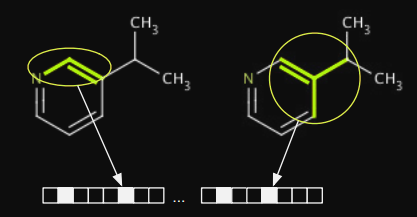

Details of RDKit Fingerprinting: https://rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

There are many different methods for doing the same. For now we stick with RDKit Fingerprints. Fingerprints attempt to characterize local features and subgraphs.

Matching subgraphs, a.k.a. subgraph isomorphism, is an NP-complete problem.

## RDKit Fingerprint Algorithm

* Substructure fingerprint
* Atom types: set by atomic number and aromaticity
* Bond types: set by atom types and bond types

Algorithm:
For each subgraph (or path, if `branchedPaths` is false) of length `minPath - maxPath` bonds:
1. Generate hash for the path using bond types and each bond’s neighbor count
2. seed random-number generator with hash
3. generate `nBitsPerHash` random numbers between 0 and fpSize and set the corresponding bits
4. [optional]: “fold” fingerprint to target density of `tgtDensity` of bits set (minimum size `minSize` bits)

In [ ]:
mol = rdkit.Chem.MolFromSmiles("C(C)(C)NC(=O)NO")
fingerprint = rdkit.Chem.RDKFingerprint(mol)
print("Number of Bits:", fingerprint.GetNumBits())
print("Number of On Bits:", fingerprint.GetNumOnBits())
array = np.array([float(digit) for digit in fingerprint.ToBitString()])
print("Full Bit String:", array)

Number of Bits: 2048
Number of On Bits: 63
Full Bit String: [0. 0. 0. ... 0. 0. 1.]


## Fingerprints for predicting Solvation Energy


In [ ]:
df = pd.read_csv("freesolv_database.csv", sep=';')
df.head()

,compound id (and file prefix),SMILES,iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem),experimental value (kcal/mol),experimental uncertainty (kcal/mol),Mobley group calculated value (GAFF) (kcal/mol),calculated uncertainty (kcal/mol),experimental reference (original or paper this value was taken from),calculated reference,text notes.
0,mobley_1017962,CCCCCC(=O)OC,methyl hexanoate,-2.49,0.6,-3.30,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availa...
1,mobley_1019269,CCCCO,butan-1-ol,-4.72,0.6,-3.23,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availa...
2,mobley_1034539,c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl,"1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)ben...",-3.04,0.1,-1.08,0.04,10.1007/s10822-012-9568-8,10.1007/s10822-011-9528-8,Experimental uncertainty not presently availa...
3,mobley_1036761,C1CCC(CC1)N,cyclohexanamine,-4.59,0.6,-3.95,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availa...
4,mobley_1046331,c1ccc(cc1)OC=O,phenyl formate,-3.82,0.6,-5.44,0.03,"J. Peter Guthrie, unpublished data, as provid...",10.1021/ct800409d,Experimental uncertainty not presently availa...


Now for each of the molecules we need to compute molecular features, which are the fingerprints. We do it and stack them up to make our inputs matrix.

In [ ]:
def featurize(smiles):
    molecule = rdkit.Chem.MolFromSmiles(smiles)
    fingerprint = rdkit.Chem.RDKFingerprint(molecule)
    x = np.array(
        [float(digit) for digit in fingerprint.ToBitString()],
        dtype=np.float32,
    )
    return x


x = np.stack(df['SMILES'].apply(featurize).values)
y = df['experimental value (kcal/mol)'].values

We perform linear regression on this feature matrix. Eventually, we 

In [ ]:
model = sklearn.linear_model.LinearRegression()
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2
)
model.fit(x_train, y_train)
print("RMS error in Train Data:", 
      np.mean(np.square(y_train - model.predict(x_train))))
print("Variance in the Train Data:", np.var(y_train))

print("RMS error in Test Data:", 
      np.mean(np.square(y_test - model.predict(x_test))))
print("Variance in the Test Data:", np.var(y_test))

RMS error in Train Data: 0.043842800468104036
Variance in the Train Data: 15.893067779981527
RMS error in Test Data: 2919.507691236721
Variance in the Test Data: 10.024928586022474


Learning linear transforms over features to predict solubility manages to overfit on training data, but fails badly on test data.

## Extended Connectivity Fingerprints

1. Compute a unique index for each atom. This is a long integer hash made using the following features (Daylight atomic invariants)

* Number of non-hydrogen immediate neighbors
* Valency minus the number of connected hydrogens (i.e., total bond order ignoring H)
* Atomic number
* Atomic mass
* Atomic charge
* Number of attached hydrogens (both implicit and explicit)

2. Aggregate information from neighboring atoms and bonds connecting to them and use it to compute new feature vector.

    `[bond-order-1, atom-1-hash, bond-order-1, atom-2-hash, ...]`

    We hash this list to generate the 1-st iteration features for the atoms. These features in the 1-st iteration grab information from radius 1, diameter 2. We repeat this proecss, the 2-nd iteration vector will have information from radius 2, diameter 4.

    We do this for 2-3 iterations, leading to the different ECFP types, **ECFP-4, ECFP-6**, etc., depending on the diameter of data aggregation. 
    
    We also keep track of which bonds and atoms are getting aggregated in each iteration, and we de-duplicate the same neighborhood being added as a feature from two different starting points.

3. Given a target vector size, say 2048, take all the computed hashes over all iterations and find their values in this mod-field. i.e. `feature-id = hash-index % 2048`.

    Marks these feature ids in a 2048 length bit-vector, which now represents a hashed list of unique atom features, and substructure features upto small radii.

The following features are important to note about ECFP:
* The Hydrogen atoms are not a part of the fingerprinting process.
* ECFP depends on the hash function implementation of each programming language and therefore may differ in value from implementation to implementation.
* ECFP-4 is sufficient for most clustering or similarity indexing tasks.
* ECFP-6 or ECFP-8 might be needed for activity prediction tasks.


Refer to https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html for a detailed explainiation.

In [ ]:
molecule = "C1CCCC1"

fingerprint = np.asarray(
    rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(
        rdkit.Chem.MolFromSmiles(molecule),
        radius=3,
        nBits=32
    )
)

print("Morgan Fingerprint of Benzene", fingerprint)

Morgan Fingerprint of Benzene [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]


Morgan fingerprint is a type of ECFP.

## Molecule Similarity

$$\text{Travsky}_{a,b}(V_i, V_j) = \frac{V_i \cdot V_j}{a ||V_i||_1 + b ||V_j||_1 + (1 - a- b) V_i \cdot V_j}$$

Travsky similarity is the general framework in which all other fingerprint similarity measures fit.

$$\text{Tanimoto}(V_i, V_j) = \text{Travsky}_{1,1}(V_i, V_j)$$

Tanimoto similarity is the ratio of the number of molecular features present in both molecules (intersection) over the number of molecular features present in either molecule (union).

$$\text{Tanimoto}(V_i, V_j) = \frac{V_i \cdot V_j}{||V_i||_1 + ||V_j||_1 - V_i \cdot V_j}$$

$$\text{Dice}(V_i, V_j) = \text{Travsky}_{0.5,0.5}(V_i, V_j)$$

Tanimoto similarity is the ratio of the number of molecular features present in both molecules (intersection) over the average number of molecular features present in both the molecules (mean of L1 norm).

$$\text{Dice}(V_i, V_j) = \frac{V_i \cdot V_j}{\frac{1}{2} ||V_i||_1 + \frac{1}{2} ||V_j||_1}$$

In [ ]:
def generate_molecule_data(batch_size=128):
    smiles, data = [], []
    with open("gdb11_size08.smi", "r") as f:
        for dataline in tqdm.tqdm(list(f.readlines())):
            smile = dataline.split()[0]
            molecule = rdkit.Chem.MolFromSmiles(smile)
            fingerprint = rdkit.Chem.RDKFingerprint(molecule)
            data.append(fingerprint)
            smiles.append(smile)
    return data, smiles

In [ ]:
fingerprints, smiles = generate_molecule_data()

  0%|          | 0/66706 [00:00<?, ?it/s]

In [ ]:
molecule_idx = np.random.randint(len(fingerprints))
similarities = [
    rdkit.DataStructs.FingerprintSimilarity(
        fingerprints[molecule_idx],
        fingerprint
    )
    for fingerprint in fingerprints
]
indexes = np.argsort(similarities)[::-1]

In [ ]:
smiles[indexes[0]], smiles[molecule_idx]

('O=C1CC(CC#C)C1', 'O=C1CC(CC#C)C1')

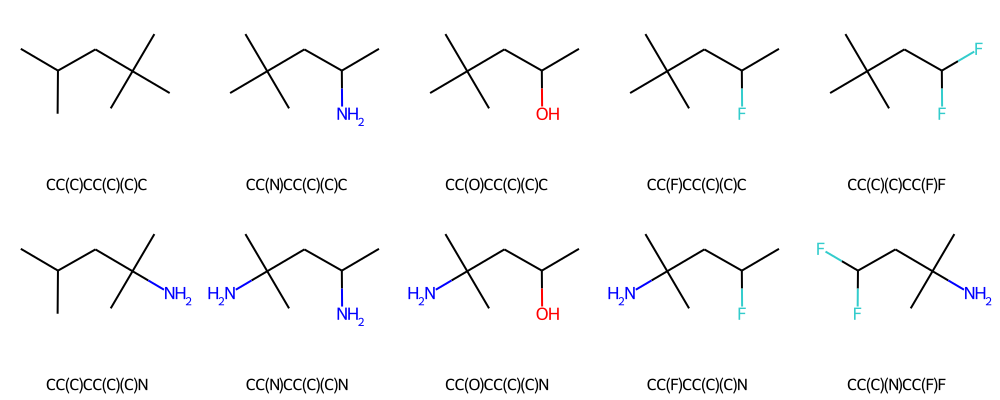

In [ ]:
img = rdkit.Chem.Draw.MolsToGridImage(
    [rdkit.Chem.MolFromSmiles(smile) for smile in smiles[:10]],
    molsPerRow=5,
    legends=smiles[:10]
)
img

## Exercise: Predict Log-p values

In [ ]:
import rdkit.Chem.Crippen

log_p = np.array([
    rdkit.Chem.Crippen.MolLogP(rdkit.Chem.MolFromSmiles(smile))
    for smile in tqdm.tqdm(smiles)
], dtype=np.float32)

  0%|          | 0/66706 [00:00<?, ?it/s]

Now you are given the list of all smiles and the list of all log-p values for those smiles. Use RDKit fingerprints and Morgan fingerprints (if it's hard to get these, see the code in the next segment) along with any other fingerprint methods of your choice, and evaluate which perform best as input to a linear regressor.

**NOTE TO TAs: Do not copy the following segment, since it's the solution to the exercise. Copy only after the exercise period is done**.

First we classify based on RDKit Fingerprints.

In [ ]:
fingerprint_array = np.array([
    list(map(float, fingerprint.ToBitString()))
    for fingerprint in tqdm.tqdm(fingerprints)
], dtype=np.float32)

  0%|          | 0/66706 [00:00<?, ?it/s]

In [ ]:
fingerprint_array.shape, log_p.shape

((66706, 2048), (66706,))

In [ ]:
model = sklearn.linear_model.LinearRegression()

fingerprint_array_train, fingerprint_array_test, log_p_train, log_p_test = \
    sklearn.model_selection.train_test_split(
        fingerprint_array, log_p, test_size=0.2)

model.fit(fingerprint_array_train, log_p_train)

print("RMS error in Test Data:",
      np.mean(np.square(log_p_train - model.predict(fingerprint_array_train))))
print("Variance in the Test Data:", np.var(log_p_train))

print("RMS error in Test Data:",
      np.mean(np.square(log_p_test - model.predict(fingerprint_array_test))))
print("Variance in the Test Data:", np.var(log_p_test))

RMS error in Test Data: 0.08701394
Variance in the Test Data: 0.96842295
RMS error in Test Data: 0.09584421
Variance in the Test Data: 0.9907389


Here we are actually able to make the predictions based on substructure hashes, this is because there might be substructures common across drug like molecules.

Now we use Morgan Fingerprints for the same classification.

In [ ]:
morgan_fingerprint_array = np.stack([
    np.asarray(
        rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(
            rdkit.Chem.MolFromSmiles(smile),
            radius=3,
            nBits=128
        )
    )
    for smile in tqdm.tqdm(smiles)
])

  0%|          | 0/66706 [00:00<?, ?it/s]

In [ ]:
model = sklearn.linear_model.LinearRegression()

fingerprint_array_train, fingerprint_array_test, log_p_train, log_p_test = \
    sklearn.model_selection.train_test_split(
        morgan_fingerprint_array, log_p, test_size=0.2)

model.fit(fingerprint_array_train, log_p_train)

print("RMS error in Test Data:",
      np.mean(np.square(log_p_train - model.predict(fingerprint_array_train))))
print("Variance in the Test Data:", np.var(log_p_train))

print("RMS error in Test Data:",
      np.mean(np.square(log_p_test - model.predict(fingerprint_array_test))))
print("Variance in the Test Data:", np.var(log_p_test))

RMS error in Test Data: 0.43637258106416094
Variance in the Test Data: 0.9726412
RMS error in Test Data: 0.43458268859452603
Variance in the Test Data: 0.9738276


**Exploratory Task:**
Play around with the number of bits and radius of features in the Morgan Fingerprint, and compare it to other fingerprint methods, both for learning and finding similar elements. Also compare the different similarity measures for clustering tasks. See Topological-Torsion fingerprints and other methods.

**Exploratory Task:**
Lookup the ChEMBL dataset for Log-p values (drug likeness), and the Tox21 dataset for the toxicity value of molecules (the input already has in the sparse features file a list of ECFP fingerprints). Run classification/regression algorithms on these using the techniques learnt above. Attempt to characterize which tasks will these fingerprint based methods work well on and provide intuitive explainations for the same.